In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
from botorch.test_functions.multi_objective import BraninCurrin
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

In [3]:
def generate_initial_data(problem, n=6):
    # generate training data
    X_obs = torch.empty(0, problem.bounds.shape[-1])
    y_obs = torch.empty(0, problem.ref_point.shape[-1])
    while len(X_obs) < n:
        x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
        y = problem(x)
        if (y > problem.ref_point).all(dim=-1).item():
            X_obs = torch.concat([X_obs, x], dim=0)
            y_obs = torch.concat([y_obs, y], dim=0)

    return X_obs, y_obs

In [4]:
problem = BraninCurrin(negate=True)
print(f"max_hv: {problem.max_hv}\nref_point: {problem.ref_point}")
X_obs, y_obs = generate_initial_data(problem, n=100)
pareto = is_non_dominated(y_obs)

max_hv: 59.36011874867746
ref_point: tensor([-18.,  -6.])


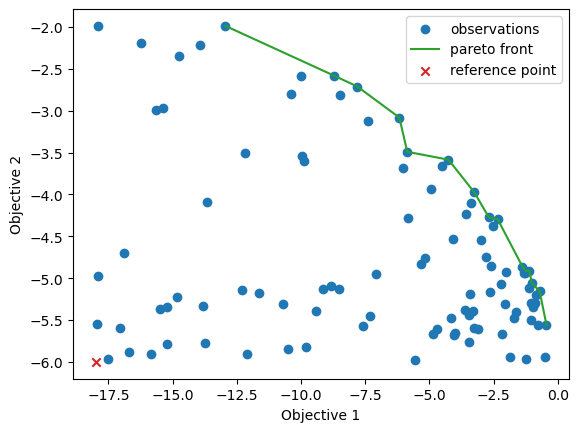

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
cm = plt.colormaps["viridis"]

ax = fig.add_subplot(1, 1, 1)
_, ind = torch.sort(y_obs[pareto][:, 0])
ax.scatter(*y_obs.t(), label='observations')
ax.plot(*y_obs[pareto][ind].t(), color='tab:green', label='pareto front')

ax.scatter(*problem.ref_point, marker='x', color='tab:red', label='reference point')

ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.legend()
plt.show()

In [6]:
# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

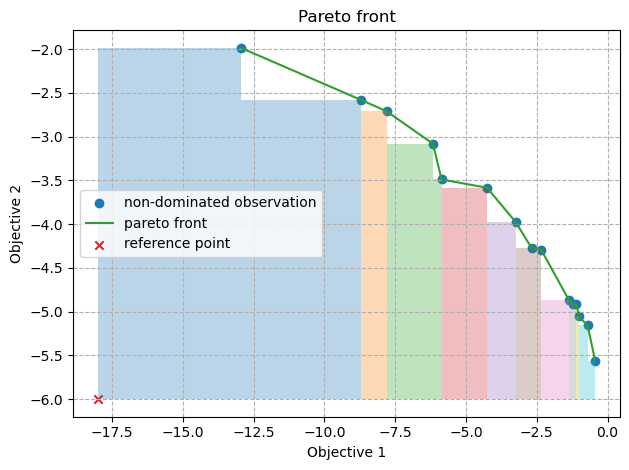

In [7]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

fig = plt.figure()
ax_pareto = fig.add_subplot(1, 1, 1)
ax_pareto.scatter(*y_obs[pareto].t(), label='non-dominated observation')
ax_pareto.plot(*y_obs[pareto][ind].t(), color='tab:green', label='pareto front')
ax_pareto.scatter(*problem.ref_point, marker='x', color='tab:red', label="reference point")

l = bd.hypercell_bounds[0]
u = bd.hypercell_bounds[1]
boxes = [Rectangle(
    l_point,
    *(u_point - l_point),
) for l_point, u_point in zip(l, u)]

pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
pc.set_array(torch.arange(0, len(l)))
ax_pareto.add_collection(pc)

ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1")
ax_pareto.set_ylabel("Objective 2")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()
plt.show()

## Hypervolume scalarization

$$ \mathcal{HV}_{z}(Y) := c_k \mathbb{E}_{\lambda \sim \mathcal{S}_{+}^{k-1}} \left[ \max_{y \in Y} s_{\lambda}(y - z) \right] $$

where $s_{\lambda}(y) = \min_i(\max(0, \frac{y_i}{\lambda_i}))^k$ and $c_k = \frac{\pi^{k/2}}{2^k \Gamma (k / 2+1)}$. $ \mathcal{S}_{+}^{k-1} = \{ \lambda \in \mathbb R^k \mid \lVert \lambda \rVert= 1, \lambda \geq 0 \} $ (from a hypersphere)

In [8]:
from botorch.utils.sampling import sample_hypersphere

In [9]:
# Ground truth
volume = bd.compute_hypervolume().item()
print(volume)

52.63327533704898


In [10]:
k = torch.tensor(y_obs.shape[-1])
hv_weights = sample_hypersphere(d=k, n=1000, qmc=True)

In [11]:
hv_weights = sample_hypersphere(d=k, n=100, qmc=True).abs().unsqueeze(1)
# dimension-independent constant
c_k = torch.pow(torch.pi, k / 2) / (torch.pow(torch.tensor(2), k) * torch.lgamma(k/2 + 1).exp())

In [12]:
# hypervolume scalarization
y = y_obs
scalar = ((y - problem.ref_point).clamp_min(0).unsqueeze(-3) / hv_weights).amin(dim=-1).pow(k).amax(dim=-1)
hv_scalar = c_k * scalar.mean()
print(hv_scalar.item())

53.06540608329703
